In [9]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, TensorDataset, DataLoader
from random import shuffle

if not torch.cuda.is_available():
    raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

### Arguments

In [10]:
args = {
    'lr': 1e-3, 
    'bs': 128, 
    'epochs': 5, 
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10, 
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50
    }

### Data

In [11]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    
    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [12]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

In [13]:
class GreedyBuffer:
    def __init__(self, samples_per_class):
        self.samples_per_class = samples_per_class
        self.samples = torch.Tensor([])
        self.targets = torch.Tensor([])

    def store_data(self, loader):
        samples, targets = torch.Tensor([]), torch.Tensor([])
        for sample, target in loader:
            samples = torch.cat((samples, sample))
            targets = torch.cat((targets, target))
        
        for label in torch.unique(targets):
            greedy_idx = torch.where(targets == label)[0][:self.samples_per_class]
            self.samples = torch.cat((self.samples, samples[greedy_idx]))
            self.targets = torch.cat((self.targets, targets[greedy_idx]))

    def get_data(self):
        return self.samples, self.targets.to(torch.int64)

    def __len__(self):
        assert len(self.samples) == len(self.targets), f"Incosistent lengths of data tensor: {self.samples.shape}, target tensor: {self.targets.shape}!"
        return len(self.samples)


## Class incremental model

In [14]:

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.buffer = GreedyBuffer(samples_per_class = 100)
    
    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}


    def train(self):
        for task, data in self.train_datasets.items():
            self.model = MLP(self.args)
            if torch.cuda.is_available():
                self.model.cuda()
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
            loader = DataLoader(data, batch_size=self.args['bs'])
            self.buffer.store_data(loader)
            print(f"Task {task} -- buffer stores {len(self.buffer)} samples")
            samples, targets = self.buffer.get_data()
            greedy_dataset = TensorDataset(samples, targets)
            greedy_loader = DataLoader(greedy_dataset, batch_size=self.args['bs'], shuffle=True)
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(greedy_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [15]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

Task 0 -- buffer stores 600 samples
Epoch 0: Loss 2.123 Acc: 0.502
Epoch 1: Loss 1.508 Acc: 0.788
Epoch 2: Loss 0.705 Acc: 0.930
Epoch 3: Loss 0.277 Acc: 0.955
Epoch 4: Loss 0.127 Acc: 0.973
Task 1 -- buffer stores 1200 samples
Epoch 0: Loss 2.247 Acc: 0.121
Epoch 1: Loss 1.584 Acc: 0.675
Epoch 2: Loss 0.741 Acc: 0.801
Epoch 3: Loss 0.410 Acc: 0.880
Epoch 4: Loss 0.249 Acc: 0.937
Task 2 -- buffer stores 1800 samples
Epoch 0: Loss 2.111 Acc: 0.282
Epoch 1: Loss 1.270 Acc: 0.738
Epoch 2: Loss 0.632 Acc: 0.821
Epoch 3: Loss 0.396 Acc: 0.877
Epoch 4: Loss 0.287 Acc: 0.904
Task 3 -- buffer stores 2400 samples
Epoch 0: Loss 2.030 Acc: 0.391
Epoch 1: Loss 1.039 Acc: 0.742
Epoch 2: Loss 0.524 Acc: 0.848
Epoch 3: Loss 0.352 Acc: 0.891
Epoch 4: Loss 0.281 Acc: 0.912
Task 4 -- buffer stores 3000 samples
Epoch 0: Loss 1.987 Acc: 0.358
Epoch 1: Loss 0.926 Acc: 0.758
Epoch 2: Loss 0.518 Acc: 0.847
Epoch 3: Loss 0.388 Acc: 0.886
Epoch 4: Loss 0.311 Acc: 0.911


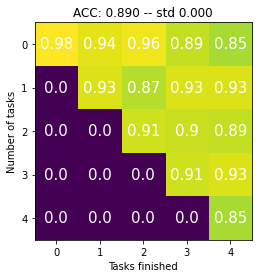

<Figure size 432x288 with 0 Axes>

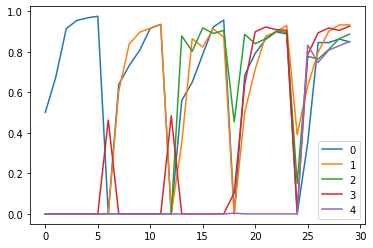

The average accuracy at the end of sequence is: 0.889
BWT:'-0.031'
FWT:'-0.120'


<Figure size 432x288 with 0 Axes>

In [16]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")